In [1]:
import re

class Roi:
    def __init__(self, roiName, roiNumber, roiType, roiCoordX, roiCoordY):
        self.name = roiName
        self.number = roiNumber
        self.type = roiType
        self.coordX = roiCoordX
        self.coordY = roiCoordY
    def __str__(self):
        return str(self.name)
def parse_mmROI(path_to_file):
    ROIs = []
    f = open(path_to_file, "r")
    for line in f:
        roiType = line[2:re.search(', 1',line).start()]
        left, top = line[re.search(', 2',line).end():re.search(', 3',line).start()].split()
        coords = line[re.search(', 6',line).end():re.search(', 7',line).start()].split()
        nbcoord = int(coords[0])
        roiCoordX = []
        roiCoordY = []
        for i in range(1,2*nbcoord+1):
            if i%2 == 1:
                roiCoordX.append(int(coords[i]))
            else:
                roiCoordY.append(int(coords[i]))
        right = roiCoordX[0]
        bottom = roiCoordY[0]
        for i in range(nbcoord):
            right = max(right, roiCoordX[i])
            bottom = max(bottom, roiCoordY[i])
        roiNumber = int(line[re.search(', 7 ',line).end():-1])
        roiName = re.findall(r'(/[^/]*\.)',path_to_file)[0][1:-1]+'-Roi no'+str(roiNumber)
        ROIs.append(Roi(roiName, roiNumber, roiType, roiCoordX, roiCoordY))
    return ROIs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage import exposure
import os

gorbsky_dir = "/data/backup/cullen/gorbsky_data/"
load_dir = gorbsky_dir+"/input_data/"
track_dir = gorbsky_dir+"tracking_videos/"
roi_dir = gorbsky_dir+"rgn_reader/"
cellID_dir = gorbsky_dir+"cell_data/"
# load_dir = "/gorbsky_data/input_data/"
files = [f[:-4] for f in sorted(os.listdir(load_dir)) if f.endswith(".tif")]

38
jd734w1p1c1-Roi no2


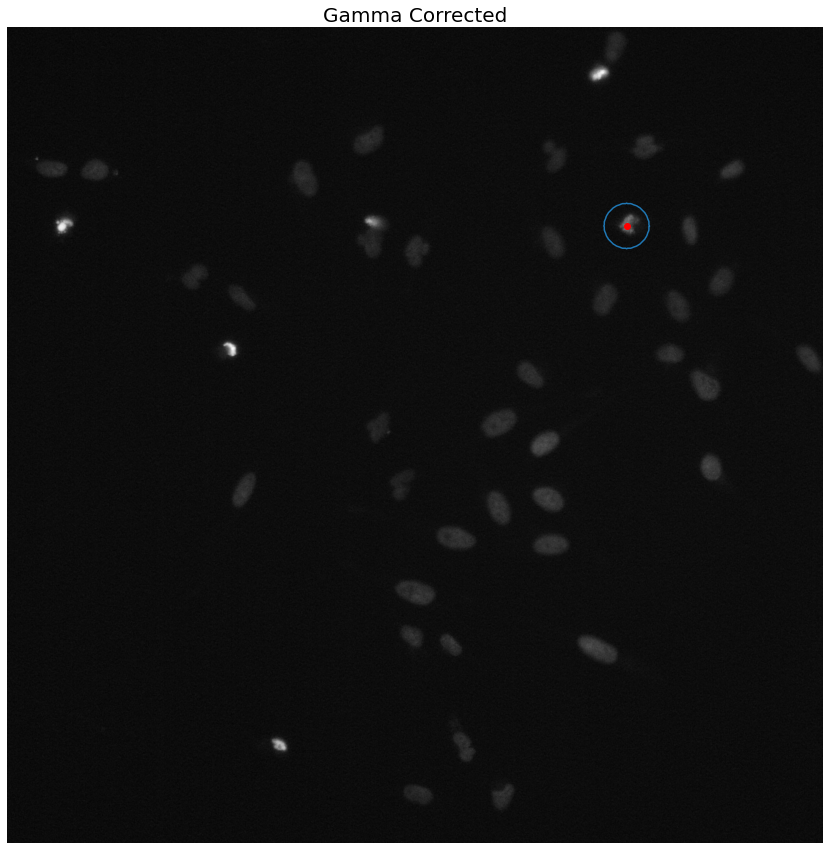

In [3]:
imgs = imread(load_dir+files[0]+".tif")
img = imgs[int(190/5)]

first_roi = parse_mmROI(roi_dir+files[0]+".rgn")[1]
print(len(parse_mmROI(roi_dir+files[0]+".rgn")))
print(first_roi.name)

plt.figure(figsize=(20, 15))

plt.plot(np.mean(first_roi.coordX),np.mean(first_roi.coordY),'ro')
plt.plot(first_roi.coordX, first_roi.coordY)
plt.imshow(exposure.adjust_gamma(img, 0.1), cmap="gray")
plt.axis('off')
plt.title("Gamma Corrected",fontsize=20)

plt.show()

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

In [5]:
# load_dir = "/home/cullen/nfs/gorbsky_data/input_data/"
# track_dir = "/home/cullen/nfs/gorbsky_data/tracking_videos/"
# roi_dir = "/home/cullen/nfs/gorbsky_data/rgn_reader/"
# cellID_dir = "/home/cullen/nfs/gorbsky_data/cell_data/"

files = [f[:-4] for f in sorted(os.listdir(load_dir)) if f.endswith(".tif")]

In [21]:
count=0
for file in files:
    count+=1
    cell_data = pd.read_csv(cellID_dir+file+".csv")
    cell_rois = parse_mmROI(roi_dir+file+".rgn")
    trackIDs = []
    treackDists = []
    for i in tqdm(range(len(cell_rois))):
        cell_roi = cell_rois[i]
        cd = cell_data.loc[i]
        avgCoords = (np.mean(cell_roi.coordX), np.mean(cell_roi.coordY))
        if np.isnan(cd['NEB']):
            trackIDs.append('')
            treackDists.append(0)
            continue
        frame = int(int(cd['NEB'])/5)
        track_videos = [f[:-4] for f in sorted(os.listdir(track_dir+file+"_tracked/")) if f.endswith(".tif")]
        minDist = 1608
        minVid = track_videos[0]
        for tv in track_videos:
            tracks = dict(np.load(track_dir+file+"_tracked/"+tv+".npy",allow_pickle=True).item())
            if frame in tracks.keys():
                coords = tracks[frame]
                dist = np.linalg.norm((avgCoords[0]-coords[0], avgCoords[1]-coords[1]))
                if dist < minDist:
                    minDist = dist
                    minVid = tv
        trackIDs.append(minVid)
        treackDists.append(minDist)
    cell_data['trackID'] = trackIDs
    cell_data['trackDist'] = treackDists
    for index, row in cell_data.iterrows():
        if row['trackDist']>30:
            cell_data = cell_data.drop(index)
    cell_data.to_csv(cellID_dir+file+".csv",index=False)
    print("{} out of {} files of cellIDs detected and saved".format(count, len(files)))

 24%|█████████████████████████████                                                                                             | 5/21 [00:00<00:00, 47.08it/s]

1 out of 11 files of cellIDs detected and saved


 15%|██████████████████                                                                                                        | 4/27 [00:00<00:00, 34.77it/s]

2 out of 11 files of cellIDs detected and saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 77.09it/s]

3 out of 11 files of cellIDs detected and saved



 29%|██████████████████████████████████▊                                                                                       | 4/14 [00:00<00:00, 36.52it/s]

4 out of 11 files of cellIDs detected and saved


  5%|█████▌                                                                                                                    | 1/22 [00:00<00:02,  9.77it/s]

5 out of 11 files of cellIDs detected and saved


  4%|████▋                                                                                                                     | 1/26 [00:00<00:03,  8.18it/s]

6 out of 11 files of cellIDs detected and saved


  9%|██████████▌                                                                                                               | 2/23 [00:00<00:01, 18.39it/s]

7 out of 11 files of cellIDs detected and saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 56.13it/s]

8 out of 11 files of cellIDs detected and saved



 25%|██████████████████████████████▌                                                                                           | 4/16 [00:00<00:00, 35.58it/s]

9 out of 11 files of cellIDs detected and saved


 13%|███████████████▉                                                                                                          | 3/23 [00:00<00:00, 21.29it/s]

10 out of 11 files of cellIDs detected and saved


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 21.13it/s]

11 out of 11 files of cellIDs detected and saved


In [26]:
cell_data = pd.read_csv(cellID_dir+files[0]+".csv")
cell_data
# cell_data.to_csv("/home/cullen/nfs/gorbsky_data/cell_data/jd734w1p3c1.csv",index=False)

cellID     NEB     Met     Ana  Fatigue  Death  Multipolar  Notes  \
0    Cell5   295.0   310.0   330.0      NaN    NaN         NaN    NaN   
1    Cell6   375.0   395.0   405.0      NaN    NaN         NaN    NaN   
2    Cell7   455.0   465.0   500.0      NaN    NaN         NaN    NaN   
3    Cell8   515.0   525.0   555.0      NaN    NaN         NaN    NaN   
4    Cell9   575.0   595.0   610.0      NaN    NaN         NaN    NaN   
5   Cell10   640.0   655.0   685.0      NaN    NaN         NaN    NaN   
6   Cell11   675.0   695.0   715.0      NaN    NaN         NaN    NaN   
7   Cell12   695.0   715.0   760.0      NaN    NaN         NaN    NaN   
8   Cell13   700.0   715.0   750.0      NaN    NaN         NaN    NaN   
9   Cell14   720.0   740.0   755.0      NaN    NaN         NaN    NaN   
10  Cell15   765.0   780.0   800.0      NaN    NaN         NaN    NaN   
11  Cell17   770.0   790.0   830.0      NaN    NaN         NaN    NaN   
12  Cell19   835.0   850.0   880.0      NaN    NaN         NaN    NaN   
13  Cell20   855.0   880.0   900.0      NaN    NaN         NaN    NaN   
14  Cell21   830.0   855.0   865.0      NaN    NaN         NaN    NaN   
15  Cell22   870.0   885.0   900.0      NaN    NaN         NaN    NaN   
16  Cell23   900.0   925.0   950.0      NaN    NaN         NaN    NaN   
17  Cell26  1205.0  1220.0  1240.0      NaN    NaN         NaN    NaN   
18  Cell28  1215.0  1235.0  1250.0      NaN    NaN         NaN    NaN   
19  Cell29  1300.0  1315.0  1350.0      NaN    NaN         NaN    NaN   
20  Cell35  1030.0  1040.0  1060.0      NaN    NaN         NaN    NaN   
21  Cell36  1190.0  1200.0  1230.0      NaN    NaN         NaN    NaN   
22  Cell37  1225.0  1245.0  1290.0      NaN    NaN         NaN    NaN   
23  Cell38  1290.0  1305.0  1340.0      NaN    NaN         NaN    NaN   

       trackID  trackDist  
0    btrack740   2.236068  
1     btrack31   3.000000  
2     btrack32   4.123106  
3     btrack42   4.123106  
4     btrack40   2.828427  
5     btrack39   1.414214  
6   btrack1891  14.866069  
7     btrack10   9.486833  
8     btrack46   4.123106  
9     btrack34   4.472136  
10    btrack30   8.544004  
11  btrack2241  15.132746  
12  btrack2540   1.000000  
13    btrack41  10.049876  
14    btrack25  14.560220  
15    btrack37   5.000000  
16    btrack58  12.165525  
17  btrack4116   2.000000  
18  btrack1798  10.440307  
19   btrack611  12.649111  
20  btrack1557  12.529964  
21     btrack3  16.000000  
22  btrack3305  13.038405  
23  btrack1873   9.219544